# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
- Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D
   - Results

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [7]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_6 (Batc  (None, 21, 100, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 1, 100, 16)        0         
                                                      

In [9]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (960, 21, 100)
Shape of train data (epochs, channels, samples): (768, 21, 100)
Shape of test data (epochs, channels, samples): (192, 21, 100)
Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 1.4384 - accuracy: 0.3056
Epoch 1: val_loss improved from inf to 1.41535, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.38542, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 5s 315ms/step - loss: 1.4384 - accuracy: 0.3056 - val_loss: 1.4153 - val_accuracy: 0.3854
Epoch 2/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.4117 - accuracy: 0.3555
Epoch 2: val_loss improved 

4/5 [=======================>......] - ETA: 0s - loss: 1.1359 - accuracy: 0.5176
Epoch 17: val_loss improved from 1.13023 to 1.11062, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy improved from 0.49479 to 0.50000, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 55ms/step - loss: 1.1355 - accuracy: 0.5139 - val_loss: 1.1106 - val_accuracy: 0.5000
Epoch 18/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.1349 - accuracy: 0.4805
Epoch 18: val_loss improved from 1.11062 to 1.09415, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 18: val_accuracy improved from 0.50000 to 0.52604, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [=====

Epoch 33/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.9206 - accuracy: 0.6172
Epoch 33: val_loss improved from 0.87330 to 0.86267, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 33: val_accuracy did not improve from 0.70312
5/5 [==============================] - 0s 50ms/step - loss: 0.9338 - accuracy: 0.6076 - val_loss: 0.8627 - val_accuracy: 0.6823
Epoch 34/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.9179 - accuracy: 0.6328
Epoch 34: val_loss improved from 0.86267 to 0.85184, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 34: val_accuracy did not improve from 0.70312
5/5 [==============================] - 0s 42ms/step - loss: 0.9279 - accuracy: 0.6267 - val_loss: 0.8518 - val_accuracy: 0.6823
Epoch 35/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.9010 - accuracy: 0.6230
Epoch 35: val_l


Epoch 52: val_accuracy improved from 0.74479 to 0.75000, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 55ms/step - loss: 0.8446 - accuracy: 0.6510 - val_loss: 0.7226 - val_accuracy: 0.7500
Epoch 53/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.8411 - accuracy: 0.6719
Epoch 53: val_loss improved from 0.72261 to 0.71480, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 53: val_accuracy improved from 0.75000 to 0.76562, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 56ms/step - loss: 0.8386 - accuracy: 0.6736 - val_loss: 0.7148 - val_accuracy: 0.7656
Epoch 54/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.8151 - accuracy: 0.6602
Epoch 54: val_loss improved from 0.71

Epoch 73/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7756 - accuracy: 0.6836
Epoch 73: val_loss did not improve from 0.65823

Epoch 73: val_accuracy did not improve from 0.79688
5/5 [==============================] - 0s 29ms/step - loss: 0.7683 - accuracy: 0.6840 - val_loss: 0.6703 - val_accuracy: 0.7760
Epoch 74/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7653 - accuracy: 0.6992
Epoch 74: val_loss did not improve from 0.65823

Epoch 74: val_accuracy did not improve from 0.79688
5/5 [==============================] - 0s 30ms/step - loss: 0.7636 - accuracy: 0.6910 - val_loss: 0.6589 - val_accuracy: 0.7708
Epoch 75/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7383 - accuracy: 0.7266
Epoch 75: val_loss improved from 0.65823 to 0.65005, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 75: val_accuracy improved from 0.79688 to 0.80208, saving model to saved_variable

Epoch 95/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6978 - accuracy: 0.7188
Epoch 95: val_loss did not improve from 0.60075

Epoch 95: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.7013 - accuracy: 0.7170 - val_loss: 0.6127 - val_accuracy: 0.7760
Epoch 96/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7312 - accuracy: 0.7168
Epoch 96: val_loss improved from 0.60075 to 0.59712, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 96: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 42ms/step - loss: 0.7369 - accuracy: 0.7135 - val_loss: 0.5971 - val_accuracy: 0.7812
Epoch 97/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7201 - accuracy: 0.7090
Epoch 97: val_loss improved from 0.59712 to 0.58547, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trai


Epoch 119: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.6860 - accuracy: 0.7378 - val_loss: 0.6043 - val_accuracy: 0.7708
Epoch 120/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6729 - accuracy: 0.7500
Epoch 120: val_loss did not improve from 0.58547

Epoch 120: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.6721 - accuracy: 0.7500 - val_loss: 0.5862 - val_accuracy: 0.7760
Epoch 121/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6365 - accuracy: 0.7598
Epoch 121: val_loss improved from 0.58547 to 0.58461, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 121: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 43ms/step - loss: 0.6441 - accuracy: 0.7517 - val_loss: 0.5846 - val_accuracy: 0.7812
Epoch 122/1000
4/5 [=======================


Epoch 143: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.6585 - accuracy: 0.7413 - val_loss: 0.5968 - val_accuracy: 0.7604
Epoch 144/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6607 - accuracy: 0.7363
Epoch 144: val_loss did not improve from 0.57852

Epoch 144: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.6504 - accuracy: 0.7448 - val_loss: 0.5913 - val_accuracy: 0.7760
Epoch 145/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5939 - accuracy: 0.7832
Epoch 145: val_loss did not improve from 0.57852

Epoch 145: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.6124 - accuracy: 0.7743 - val_loss: 0.5939 - val_accuracy: 0.7760
Epoch 146/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6398 - accuracy: 0.7539
Epoch 146: val_loss did not improve from 0.57852

Epoch 146: val_acc

Epoch 168/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6350 - accuracy: 0.7676
Epoch 168: val_loss did not improve from 0.57048

Epoch 168: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.6147 - accuracy: 0.7795 - val_loss: 0.5790 - val_accuracy: 0.7969
Epoch 169/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6245 - accuracy: 0.7559
Epoch 169: val_loss did not improve from 0.57048

Epoch 169: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.6225 - accuracy: 0.7587 - val_loss: 0.5804 - val_accuracy: 0.7708
Epoch 170/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6444 - accuracy: 0.7539
Epoch 170: val_loss improved from 0.57048 to 0.56853, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 170: val_accuracy did not improve from 0.80208
5/5 [=====================

Epoch 193/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6232 - accuracy: 0.7480
Epoch 193: val_loss did not improve from 0.56853

Epoch 193: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.6300 - accuracy: 0.7396 - val_loss: 0.5860 - val_accuracy: 0.7812
Epoch 194/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6171 - accuracy: 0.7754
Epoch 194: val_loss did not improve from 0.56853

Epoch 194: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.6066 - accuracy: 0.7795 - val_loss: 0.5874 - val_accuracy: 0.7604
Epoch 195/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6101 - accuracy: 0.7637
Epoch 195: val_loss did not improve from 0.56853

Epoch 195: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 32ms/step - loss: 0.6078 - accuracy: 0.7656 - val_loss: 0.5938 - val_accuracy: 0.7656
Epoch 196/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.5784 - accuracy: 0.7695
Epoch 218: val_loss did not improve from 0.56853

Epoch 218: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5743 - accuracy: 0.7743 - val_loss: 0.6113 - val_accuracy: 0.7760
Epoch 219/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6217 - accuracy: 0.7598
Epoch 219: val_loss did not improve from 0.56853

Epoch 219: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.6097 - accuracy: 0.7708 - val_loss: 0.6176 - val_accuracy: 0.7500
Epoch 220/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5934 - accuracy: 0.7734
Epoch 220: val_loss did not improve from 0.56853

Epoch 220: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5874 - accuracy: 0.7760 - val_loss: 0.6288 - val_accuracy: 0.7448
Epoch 221/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.5420 - accuracy: 0.7871
Epoch 243: val_loss did not improve from 0.56853

Epoch 243: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 33ms/step - loss: 0.5360 - accuracy: 0.7917 - val_loss: 0.6023 - val_accuracy: 0.7760
Epoch 244/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6012 - accuracy: 0.7656
Epoch 244: val_loss did not improve from 0.56853

Epoch 244: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.6158 - accuracy: 0.7517 - val_loss: 0.6106 - val_accuracy: 0.7760
Epoch 245/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5703 - accuracy: 0.7676
Epoch 245: val_loss did not improve from 0.56853

Epoch 245: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5871 - accuracy: 0.7604 - val_loss: 0.6371 - val_accuracy: 0.7708
Epoch 246/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.5557 - accuracy: 0.7910
Epoch 268: val_loss did not improve from 0.56853

Epoch 268: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.5525 - accuracy: 0.7934 - val_loss: 0.6469 - val_accuracy: 0.7708
Epoch 269/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5693 - accuracy: 0.7734
Epoch 269: val_loss did not improve from 0.56853

Epoch 269: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.5700 - accuracy: 0.7743 - val_loss: 0.6448 - val_accuracy: 0.7656
Epoch 270/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5502 - accuracy: 0.7949
Epoch 270: val_loss did not improve from 0.56853

Epoch 270: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5617 - accuracy: 0.7899 - val_loss: 0.6489 - val_accuracy: 0.7604
Epoch 271/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.5739 - accuracy: 0.7773
Epoch 293: val_loss did not improve from 0.56853

Epoch 293: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5619 - accuracy: 0.7812 - val_loss: 0.6315 - val_accuracy: 0.7760
Epoch 294/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5533 - accuracy: 0.7695
Epoch 294: val_loss did not improve from 0.56853

Epoch 294: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5596 - accuracy: 0.7708 - val_loss: 0.6372 - val_accuracy: 0.7708
Epoch 295/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5362 - accuracy: 0.7832
Epoch 295: val_loss did not improve from 0.56853

Epoch 295: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5354 - accuracy: 0.7882 - val_loss: 0.6525 - val_accuracy: 0.7604
Epoch 296/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.5205 - accuracy: 0.8008
Epoch 318: val_loss did not improve from 0.56853

Epoch 318: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.5217 - accuracy: 0.8003 - val_loss: 0.6181 - val_accuracy: 0.7760
Epoch 319/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5397 - accuracy: 0.7891
Epoch 319: val_loss did not improve from 0.56853

Epoch 319: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5315 - accuracy: 0.7934 - val_loss: 0.6202 - val_accuracy: 0.7760
Epoch 320/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5397 - accuracy: 0.7910
Epoch 320: val_loss did not improve from 0.56853

Epoch 320: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5335 - accuracy: 0.7986 - val_loss: 0.6184 - val_accuracy: 0.7917
Epoch 321/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.5016 - accuracy: 0.8203
Epoch 343: val_loss did not improve from 0.56853

Epoch 343: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.5119 - accuracy: 0.8108 - val_loss: 0.6268 - val_accuracy: 0.7760
Epoch 344/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5336 - accuracy: 0.7969
Epoch 344: val_loss did not improve from 0.56853

Epoch 344: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.5348 - accuracy: 0.7951 - val_loss: 0.6233 - val_accuracy: 0.7760
Epoch 345/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5301 - accuracy: 0.7969
Epoch 345: val_loss did not improve from 0.56853

Epoch 345: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.5354 - accuracy: 0.7951 - val_loss: 0.6361 - val_accuracy: 0.7812
Epoch 346/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4684 - accuracy: 0.8223
Epoch 368: val_loss did not improve from 0.56853

Epoch 368: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4926 - accuracy: 0.8142 - val_loss: 0.6985 - val_accuracy: 0.7552
Epoch 369/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4752 - accuracy: 0.8379
Epoch 369: val_loss did not improve from 0.56853

Epoch 369: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4904 - accuracy: 0.8229 - val_loss: 0.6957 - val_accuracy: 0.7656
Epoch 370/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5130 - accuracy: 0.7793
Epoch 370: val_loss did not improve from 0.56853

Epoch 370: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.5093 - accuracy: 0.7812 - val_loss: 0.6807 - val_accuracy: 0.7656
Epoch 371/1000
4/5 [==============

3/5 [=================>............] - ETA: 0s - loss: 0.5186 - accuracy: 0.8073
Epoch 393: val_loss did not improve from 0.56853

Epoch 393: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 36ms/step - loss: 0.5223 - accuracy: 0.8177 - val_loss: 0.6711 - val_accuracy: 0.7708
Epoch 394/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5182 - accuracy: 0.7988
Epoch 394: val_loss did not improve from 0.56853

Epoch 394: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 32ms/step - loss: 0.5258 - accuracy: 0.7986 - val_loss: 0.6579 - val_accuracy: 0.7552
Epoch 395/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4793 - accuracy: 0.8281
Epoch 395: val_loss did not improve from 0.56853

Epoch 395: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 36ms/step - loss: 0.4750 - accuracy: 0.8264 - val_loss: 0.6610 - val_accuracy: 0.7552
Epoch 396/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.5029 - accuracy: 0.8125
Epoch 418: val_loss did not improve from 0.56853

Epoch 418: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.4940 - accuracy: 0.8160 - val_loss: 0.6661 - val_accuracy: 0.7708
Epoch 419/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5060 - accuracy: 0.7852
Epoch 419: val_loss did not improve from 0.56853

Epoch 419: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4955 - accuracy: 0.7899 - val_loss: 0.6682 - val_accuracy: 0.7396
Epoch 420/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4749 - accuracy: 0.8145
Epoch 420: val_loss did not improve from 0.56853

Epoch 420: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4875 - accuracy: 0.8090 - val_loss: 0.6698 - val_accuracy: 0.7708
Epoch 421/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4827 - accuracy: 0.8242
Epoch 443: val_loss did not improve from 0.56853

Epoch 443: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4900 - accuracy: 0.8194 - val_loss: 0.6796 - val_accuracy: 0.7396
Epoch 444/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4593 - accuracy: 0.8359
Epoch 444: val_loss did not improve from 0.56853

Epoch 444: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4912 - accuracy: 0.8194 - val_loss: 0.6649 - val_accuracy: 0.7656
Epoch 445/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4930 - accuracy: 0.7910
Epoch 445: val_loss did not improve from 0.56853

Epoch 445: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4937 - accuracy: 0.7969 - val_loss: 0.6576 - val_accuracy: 0.7500
Epoch 446/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4740 - accuracy: 0.8164
Epoch 468: val_loss did not improve from 0.56853

Epoch 468: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4953 - accuracy: 0.8021 - val_loss: 0.6663 - val_accuracy: 0.7656
Epoch 469/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5486 - accuracy: 0.7988
Epoch 469: val_loss did not improve from 0.56853

Epoch 469: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.5303 - accuracy: 0.8056 - val_loss: 0.6651 - val_accuracy: 0.7448
Epoch 470/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4487 - accuracy: 0.8516
Epoch 470: val_loss did not improve from 0.56853

Epoch 470: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4653 - accuracy: 0.8403 - val_loss: 0.6673 - val_accuracy: 0.7396
Epoch 471/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4776 - accuracy: 0.8301
Epoch 493: val_loss did not improve from 0.56853

Epoch 493: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4763 - accuracy: 0.8281 - val_loss: 0.6552 - val_accuracy: 0.7604
Epoch 494/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4758 - accuracy: 0.8340
Epoch 494: val_loss did not improve from 0.56853

Epoch 494: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4788 - accuracy: 0.8351 - val_loss: 0.6747 - val_accuracy: 0.7500
Epoch 495/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4682 - accuracy: 0.8340
Epoch 495: val_loss did not improve from 0.56853

Epoch 495: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4704 - accuracy: 0.8351 - val_loss: 0.6946 - val_accuracy: 0.7292
Epoch 496/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4578 - accuracy: 0.8262
Epoch 518: val_loss did not improve from 0.56853

Epoch 518: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 35ms/step - loss: 0.4570 - accuracy: 0.8333 - val_loss: 0.6844 - val_accuracy: 0.7344
Epoch 519/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4380 - accuracy: 0.8477
Epoch 519: val_loss did not improve from 0.56853

Epoch 519: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4429 - accuracy: 0.8420 - val_loss: 0.6889 - val_accuracy: 0.7344
Epoch 520/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4343 - accuracy: 0.8496
Epoch 520: val_loss did not improve from 0.56853

Epoch 520: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4251 - accuracy: 0.8542 - val_loss: 0.6877 - val_accuracy: 0.7500
Epoch 521/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4474 - accuracy: 0.8320
Epoch 543: val_loss did not improve from 0.56853

Epoch 543: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.4427 - accuracy: 0.8333 - val_loss: 0.6970 - val_accuracy: 0.7135
Epoch 544/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4805 - accuracy: 0.8281
Epoch 544: val_loss did not improve from 0.56853

Epoch 544: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4853 - accuracy: 0.8281 - val_loss: 0.6986 - val_accuracy: 0.7240
Epoch 545/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4324 - accuracy: 0.8496
Epoch 545: val_loss did not improve from 0.56853

Epoch 545: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 33ms/step - loss: 0.4389 - accuracy: 0.8438 - val_loss: 0.7010 - val_accuracy: 0.7344
Epoch 546/1000
5/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4552 - accuracy: 0.8320
Epoch 568: val_loss did not improve from 0.56853

Epoch 568: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 32ms/step - loss: 0.4569 - accuracy: 0.8299 - val_loss: 0.6800 - val_accuracy: 0.7500
Epoch 569/1000
3/5 [=================>............] - ETA: 0s - loss: 0.4604 - accuracy: 0.8229
Epoch 569: val_loss did not improve from 0.56853

Epoch 569: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 32ms/step - loss: 0.4704 - accuracy: 0.8212 - val_loss: 0.6758 - val_accuracy: 0.7396
Epoch 570/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4500 - accuracy: 0.8398
Epoch 570: val_loss did not improve from 0.56853

Epoch 570: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.4478 - accuracy: 0.8438 - val_loss: 0.6731 - val_accuracy: 0.7292
Epoch 571/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4613 - accuracy: 0.8379
Epoch 593: val_loss did not improve from 0.56853

Epoch 593: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4630 - accuracy: 0.8351 - val_loss: 0.6962 - val_accuracy: 0.7500
Epoch 594/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4507 - accuracy: 0.8379
Epoch 594: val_loss did not improve from 0.56853

Epoch 594: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4361 - accuracy: 0.8420 - val_loss: 0.6951 - val_accuracy: 0.7552
Epoch 595/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5026 - accuracy: 0.8203
Epoch 595: val_loss did not improve from 0.56853

Epoch 595: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4847 - accuracy: 0.8264 - val_loss: 0.6899 - val_accuracy: 0.7500
Epoch 596/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4246 - accuracy: 0.8594
Epoch 618: val_loss did not improve from 0.56853

Epoch 618: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4297 - accuracy: 0.8507 - val_loss: 0.6632 - val_accuracy: 0.7448
Epoch 619/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4417 - accuracy: 0.8496
Epoch 619: val_loss did not improve from 0.56853

Epoch 619: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4339 - accuracy: 0.8542 - val_loss: 0.6732 - val_accuracy: 0.7240
Epoch 620/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4132 - accuracy: 0.8770
Epoch 620: val_loss did not improve from 0.56853

Epoch 620: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4229 - accuracy: 0.8733 - val_loss: 0.6820 - val_accuracy: 0.7240
Epoch 621/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4055 - accuracy: 0.8613
Epoch 643: val_loss did not improve from 0.56853

Epoch 643: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.4178 - accuracy: 0.8576 - val_loss: 0.6773 - val_accuracy: 0.7344
Epoch 644/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4810 - accuracy: 0.8086
Epoch 644: val_loss did not improve from 0.56853

Epoch 644: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4731 - accuracy: 0.8125 - val_loss: 0.6859 - val_accuracy: 0.7552
Epoch 645/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4278 - accuracy: 0.8438
Epoch 645: val_loss did not improve from 0.56853

Epoch 645: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4571 - accuracy: 0.8316 - val_loss: 0.6954 - val_accuracy: 0.7500
Epoch 646/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4160 - accuracy: 0.8652
Epoch 668: val_loss did not improve from 0.56853

Epoch 668: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4097 - accuracy: 0.8698 - val_loss: 0.7096 - val_accuracy: 0.7240
Epoch 669/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3950 - accuracy: 0.8848
Epoch 669: val_loss did not improve from 0.56853

Epoch 669: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3979 - accuracy: 0.8819 - val_loss: 0.7101 - val_accuracy: 0.7188
Epoch 670/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4502 - accuracy: 0.8496
Epoch 670: val_loss did not improve from 0.56853

Epoch 670: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4377 - accuracy: 0.8524 - val_loss: 0.6976 - val_accuracy: 0.7292
Epoch 671/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4274 - accuracy: 0.8398
Epoch 693: val_loss did not improve from 0.56853

Epoch 693: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4340 - accuracy: 0.8333 - val_loss: 0.6972 - val_accuracy: 0.7292
Epoch 694/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4481 - accuracy: 0.8438
Epoch 694: val_loss did not improve from 0.56853

Epoch 694: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 37ms/step - loss: 0.4437 - accuracy: 0.8455 - val_loss: 0.7063 - val_accuracy: 0.7292
Epoch 695/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4439 - accuracy: 0.8574
Epoch 695: val_loss did not improve from 0.56853

Epoch 695: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.4336 - accuracy: 0.8611 - val_loss: 0.7115 - val_accuracy: 0.7396
Epoch 696/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4456 - accuracy: 0.8301
Epoch 718: val_loss did not improve from 0.56853

Epoch 718: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4358 - accuracy: 0.8385 - val_loss: 0.7219 - val_accuracy: 0.7344
Epoch 719/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4179 - accuracy: 0.8574
Epoch 719: val_loss did not improve from 0.56853

Epoch 719: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4185 - accuracy: 0.8507 - val_loss: 0.7300 - val_accuracy: 0.7292
Epoch 720/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4185 - accuracy: 0.8594
Epoch 720: val_loss did not improve from 0.56853

Epoch 720: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4098 - accuracy: 0.8663 - val_loss: 0.7173 - val_accuracy: 0.7292
Epoch 721/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4271 - accuracy: 0.8555
Epoch 743: val_loss did not improve from 0.56853

Epoch 743: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4385 - accuracy: 0.8438 - val_loss: 0.7035 - val_accuracy: 0.7396
Epoch 744/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4189 - accuracy: 0.8574
Epoch 744: val_loss did not improve from 0.56853

Epoch 744: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.4243 - accuracy: 0.8559 - val_loss: 0.7100 - val_accuracy: 0.7396
Epoch 745/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4294 - accuracy: 0.8652
Epoch 745: val_loss did not improve from 0.56853

Epoch 745: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4276 - accuracy: 0.8611 - val_loss: 0.7061 - val_accuracy: 0.7448
Epoch 746/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4019 - accuracy: 0.8789
Epoch 768: val_loss did not improve from 0.56853

Epoch 768: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4018 - accuracy: 0.8715 - val_loss: 0.6974 - val_accuracy: 0.7552
Epoch 769/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4504 - accuracy: 0.8438
Epoch 769: val_loss did not improve from 0.56853

Epoch 769: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.4462 - accuracy: 0.8420 - val_loss: 0.6954 - val_accuracy: 0.7500
Epoch 770/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3982 - accuracy: 0.8770
Epoch 770: val_loss did not improve from 0.56853

Epoch 770: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 34ms/step - loss: 0.4017 - accuracy: 0.8698 - val_loss: 0.7014 - val_accuracy: 0.7292
Epoch 771/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4151 - accuracy: 0.8652
Epoch 793: val_loss did not improve from 0.56853

Epoch 793: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 33ms/step - loss: 0.4104 - accuracy: 0.8646 - val_loss: 0.7138 - val_accuracy: 0.7552
Epoch 794/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3916 - accuracy: 0.8652
Epoch 794: val_loss did not improve from 0.56853

Epoch 794: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.3986 - accuracy: 0.8663 - val_loss: 0.7072 - val_accuracy: 0.7500
Epoch 795/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4081 - accuracy: 0.8516
Epoch 795: val_loss did not improve from 0.56853

Epoch 795: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 27ms/step - loss: 0.4112 - accuracy: 0.8507 - val_loss: 0.7185 - val_accuracy: 0.7344
Epoch 796/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4133 - accuracy: 0.8652
Epoch 818: val_loss did not improve from 0.56853

Epoch 818: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.3998 - accuracy: 0.8681 - val_loss: 0.6839 - val_accuracy: 0.7240
Epoch 819/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3769 - accuracy: 0.8809
Epoch 819: val_loss did not improve from 0.56853

Epoch 819: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.3736 - accuracy: 0.8802 - val_loss: 0.6898 - val_accuracy: 0.7396
Epoch 820/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3951 - accuracy: 0.8672
Epoch 820: val_loss did not improve from 0.56853

Epoch 820: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 36ms/step - loss: 0.4152 - accuracy: 0.8542 - val_loss: 0.6921 - val_accuracy: 0.7396
Epoch 821/1000
4/5 [==============

3/5 [=================>............] - ETA: 0s - loss: 0.3761 - accuracy: 0.8750
Epoch 843: val_loss did not improve from 0.56853

Epoch 843: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 35ms/step - loss: 0.3901 - accuracy: 0.8698 - val_loss: 0.7187 - val_accuracy: 0.7188
Epoch 844/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3725 - accuracy: 0.8691
Epoch 844: val_loss did not improve from 0.56853

Epoch 844: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 33ms/step - loss: 0.3686 - accuracy: 0.8733 - val_loss: 0.7078 - val_accuracy: 0.7188
Epoch 845/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4226 - accuracy: 0.8574
Epoch 845: val_loss did not improve from 0.56853

Epoch 845: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 32ms/step - loss: 0.4147 - accuracy: 0.8628 - val_loss: 0.7013 - val_accuracy: 0.7344
Epoch 846/1000
4/5 [==============

3/5 [=================>............] - ETA: 0s - loss: 0.3854 - accuracy: 0.8698
Epoch 868: val_loss did not improve from 0.56853

Epoch 868: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 36ms/step - loss: 0.3855 - accuracy: 0.8698 - val_loss: 0.7196 - val_accuracy: 0.7396
Epoch 869/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3889 - accuracy: 0.8730
Epoch 869: val_loss did not improve from 0.56853

Epoch 869: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3889 - accuracy: 0.8733 - val_loss: 0.7239 - val_accuracy: 0.7448
Epoch 870/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3979 - accuracy: 0.8711
Epoch 870: val_loss did not improve from 0.56853

Epoch 870: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3950 - accuracy: 0.8715 - val_loss: 0.7100 - val_accuracy: 0.7292
Epoch 871/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3848 - accuracy: 0.8672
Epoch 893: val_loss did not improve from 0.56853

Epoch 893: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3873 - accuracy: 0.8681 - val_loss: 0.7081 - val_accuracy: 0.7344
Epoch 894/1000
3/5 [=================>............] - ETA: 0s - loss: 0.3476 - accuracy: 0.8880
Epoch 894: val_loss did not improve from 0.56853

Epoch 894: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 34ms/step - loss: 0.3710 - accuracy: 0.8733 - val_loss: 0.7338 - val_accuracy: 0.7240
Epoch 895/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3504 - accuracy: 0.9023
Epoch 895: val_loss did not improve from 0.56853

Epoch 895: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3654 - accuracy: 0.8906 - val_loss: 0.7244 - val_accuracy: 0.7188
Epoch 896/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4031 - accuracy: 0.8516
Epoch 918: val_loss did not improve from 0.56853

Epoch 918: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.4113 - accuracy: 0.8490 - val_loss: 0.7434 - val_accuracy: 0.7031
Epoch 919/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3774 - accuracy: 0.8887
Epoch 919: val_loss did not improve from 0.56853

Epoch 919: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 27ms/step - loss: 0.3856 - accuracy: 0.8802 - val_loss: 0.7473 - val_accuracy: 0.7188
Epoch 920/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3908 - accuracy: 0.8477
Epoch 920: val_loss did not improve from 0.56853

Epoch 920: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3870 - accuracy: 0.8524 - val_loss: 0.7364 - val_accuracy: 0.7240
Epoch 921/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3822 - accuracy: 0.8691
Epoch 943: val_loss did not improve from 0.56853

Epoch 943: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 31ms/step - loss: 0.3939 - accuracy: 0.8646 - val_loss: 0.7535 - val_accuracy: 0.7188
Epoch 944/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3696 - accuracy: 0.8906
Epoch 944: val_loss did not improve from 0.56853

Epoch 944: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3860 - accuracy: 0.8819 - val_loss: 0.7403 - val_accuracy: 0.7344
Epoch 945/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3687 - accuracy: 0.8848
Epoch 945: val_loss did not improve from 0.56853

Epoch 945: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3680 - accuracy: 0.8872 - val_loss: 0.7439 - val_accuracy: 0.7500
Epoch 946/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3521 - accuracy: 0.8906
Epoch 968: val_loss did not improve from 0.56853

Epoch 968: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.3584 - accuracy: 0.8906 - val_loss: 0.7166 - val_accuracy: 0.7396
Epoch 969/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3671 - accuracy: 0.8828
Epoch 969: val_loss did not improve from 0.56853

Epoch 969: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 29ms/step - loss: 0.3760 - accuracy: 0.8802 - val_loss: 0.7642 - val_accuracy: 0.7188
Epoch 970/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3511 - accuracy: 0.8945
Epoch 970: val_loss did not improve from 0.56853

Epoch 970: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.3456 - accuracy: 0.8958 - val_loss: 0.7679 - val_accuracy: 0.7240
Epoch 971/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3814 - accuracy: 0.8672
Epoch 993: val_loss did not improve from 0.56853

Epoch 993: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3787 - accuracy: 0.8715 - val_loss: 0.7617 - val_accuracy: 0.7240
Epoch 994/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3852 - accuracy: 0.8594
Epoch 994: val_loss did not improve from 0.56853

Epoch 994: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 30ms/step - loss: 0.3723 - accuracy: 0.8628 - val_loss: 0.7488 - val_accuracy: 0.7135
Epoch 995/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3314 - accuracy: 0.9082
Epoch 995: val_loss did not improve from 0.56853

Epoch 995: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 28ms/step - loss: 0.3424 - accuracy: 0.8993 - val_loss: 0.7445 - val_accuracy: 0.7188
Epoch 996/1000
4/5 [==============


Epoch 11: val_accuracy did not improve from 0.66146
5/5 [==============================] - 0s 42ms/step - loss: 1.1029 - accuracy: 0.5704 - val_loss: 1.0916 - val_accuracy: 0.5990
Epoch 12/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.0952 - accuracy: 0.5781
Epoch 12: val_loss improved from 1.09156 to 1.05087, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 12: val_accuracy improved from 0.66146 to 0.69792, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 55ms/step - loss: 1.0956 - accuracy: 0.5791 - val_loss: 1.0509 - val_accuracy: 0.6979
Epoch 13/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.0594 - accuracy: 0.5957
Epoch 13: val_loss improved from 1.05087 to 1.01198, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_


Epoch 29: val_accuracy improved from 0.79167 to 0.80729, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 0.7427 - accuracy: 0.7235 - val_loss: 0.6832 - val_accuracy: 0.8073
Epoch 30/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7618 - accuracy: 0.7031
Epoch 30: val_loss improved from 0.68321 to 0.66878, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 30: val_accuracy did not improve from 0.80729
5/5 [==============================] - 0s 40ms/step - loss: 0.7561 - accuracy: 0.7061 - val_loss: 0.6688 - val_accuracy: 0.7969
Epoch 31/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7337 - accuracy: 0.7305
Epoch 31: val_loss did not improve from 0.66878

Epoch 31: val_accuracy did not improve from 0.80729
5/5 [==============================] - 0s 29ms/step - los

Epoch 49/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6132 - accuracy: 0.7676
Epoch 49: val_loss improved from 0.55584 to 0.54783, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 49: val_accuracy did not improve from 0.84896
5/5 [==============================] - 0s 42ms/step - loss: 0.6382 - accuracy: 0.7496 - val_loss: 0.5478 - val_accuracy: 0.8385
Epoch 50/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6304 - accuracy: 0.7715
Epoch 50: val_loss did not improve from 0.54783

Epoch 50: val_accuracy did not improve from 0.84896
5/5 [==============================] - 0s 31ms/step - loss: 0.6171 - accuracy: 0.7791 - val_loss: 0.5518 - val_accuracy: 0.8385
Epoch 51/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6110 - accuracy: 0.7676
Epoch 51: val_loss did not improve from 0.54783

Epoch 51: val_accuracy did not improve from 0.84896
5/5 [==============================


Epoch 69: val_accuracy did not improve from 0.85938
5/5 [==============================] - 0s 55ms/step - loss: 0.5586 - accuracy: 0.7983 - val_loss: 0.4988 - val_accuracy: 0.8490
Epoch 70/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5704 - accuracy: 0.7891
Epoch 70: val_loss improved from 0.49875 to 0.49675, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 70: val_accuracy did not improve from 0.85938
5/5 [==============================] - 0s 47ms/step - loss: 0.5569 - accuracy: 0.7965 - val_loss: 0.4968 - val_accuracy: 0.8438
Epoch 71/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5482 - accuracy: 0.8047
Epoch 71: val_loss improved from 0.49675 to 0.49392, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 71: val_accuracy did not improve from 0.85938
5/5 [==============================] - 0s 51ms/step - los

4/5 [=======================>......] - ETA: 0s - loss: 0.4572 - accuracy: 0.8535
Epoch 90: val_loss did not improve from 0.45114

Epoch 90: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 30ms/step - loss: 0.4532 - accuracy: 0.8574 - val_loss: 0.4722 - val_accuracy: 0.8490
Epoch 91/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5317 - accuracy: 0.8145
Epoch 91: val_loss did not improve from 0.45114

Epoch 91: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 30ms/step - loss: 0.5306 - accuracy: 0.8087 - val_loss: 0.4706 - val_accuracy: 0.8542
Epoch 92/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4974 - accuracy: 0.8223
Epoch 92: val_loss did not improve from 0.45114

Epoch 92: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 29ms/step - loss: 0.4935 - accuracy: 0.8174 - val_loss: 0.4652 - val_accuracy: 0.8490
Epoch 93/1000
4/5 [=======================

5/5 [==============================] - 0s 28ms/step - loss: 0.4411 - accuracy: 0.8539 - val_loss: 0.4349 - val_accuracy: 0.8646
Epoch 113/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4336 - accuracy: 0.8438
Epoch 113: val_loss did not improve from 0.41977

Epoch 113: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 30ms/step - loss: 0.4528 - accuracy: 0.8383 - val_loss: 0.4390 - val_accuracy: 0.8594
Epoch 114/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4351 - accuracy: 0.8359
Epoch 114: val_loss did not improve from 0.41977

Epoch 114: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 29ms/step - loss: 0.4326 - accuracy: 0.8417 - val_loss: 0.4490 - val_accuracy: 0.8542
Epoch 115/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4382 - accuracy: 0.8516
Epoch 115: val_loss did not improve from 0.41977

Epoch 115: val_accuracy did not improve from 0.89062
5/5 [==============


Epoch 136: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 43ms/step - loss: 0.4130 - accuracy: 0.8609 - val_loss: 0.4068 - val_accuracy: 0.8802
Epoch 137/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4106 - accuracy: 0.8652
Epoch 137: val_loss improved from 0.40679 to 0.40152, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 137: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 44ms/step - loss: 0.3992 - accuracy: 0.8696 - val_loss: 0.4015 - val_accuracy: 0.8854
Epoch 138/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4101 - accuracy: 0.8691
Epoch 138: val_loss improved from 0.40152 to 0.39878, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 138: val_accuracy did not improve from 0.89062
5/5 [==============================] - 0s 44ms/ste

Epoch 160/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3702 - accuracy: 0.8906
Epoch 160: val_loss did not improve from 0.38496

Epoch 160: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 28ms/step - loss: 0.3718 - accuracy: 0.8904 - val_loss: 0.4080 - val_accuracy: 0.8750
Epoch 161/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3978 - accuracy: 0.8672
Epoch 161: val_loss did not improve from 0.38496

Epoch 161: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 29ms/step - loss: 0.3777 - accuracy: 0.8765 - val_loss: 0.4081 - val_accuracy: 0.8802
Epoch 162/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3536 - accuracy: 0.8887
Epoch 162: val_loss did not improve from 0.38496

Epoch 162: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 29ms/step - loss: 0.3640 - accuracy: 0.8835 - val_loss: 0.4123 - val_accuracy: 0.8802
Epoch 163/1000
4/5 

Epoch 185/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3502 - accuracy: 0.8984
Epoch 185: val_loss did not improve from 0.36940

Epoch 185: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 28ms/step - loss: 0.3701 - accuracy: 0.8887 - val_loss: 0.3928 - val_accuracy: 0.8854
Epoch 186/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3470 - accuracy: 0.8809
Epoch 186: val_loss did not improve from 0.36940

Epoch 186: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 28ms/step - loss: 0.3404 - accuracy: 0.8852 - val_loss: 0.4007 - val_accuracy: 0.8750
Epoch 187/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3353 - accuracy: 0.8867
Epoch 187: val_loss did not improve from 0.36940

Epoch 187: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 29ms/step - loss: 0.3320 - accuracy: 0.8887 - val_loss: 0.4060 - val_accuracy: 0.8698
Epoch 188/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3833 - accuracy: 0.8613
Epoch 210: val_loss did not improve from 0.36940

Epoch 210: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 30ms/step - loss: 0.3676 - accuracy: 0.8730 - val_loss: 0.4080 - val_accuracy: 0.8646
Epoch 211/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3492 - accuracy: 0.8906
Epoch 211: val_loss did not improve from 0.36940

Epoch 211: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 29ms/step - loss: 0.3453 - accuracy: 0.8922 - val_loss: 0.3996 - val_accuracy: 0.8698
Epoch 212/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3269 - accuracy: 0.8809
Epoch 212: val_loss did not improve from 0.36940

Epoch 212: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 29ms/step - loss: 0.3403 - accuracy: 0.8783 - val_loss: 0.3871 - val_accuracy: 0.8802
Epoch 213/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2809 - accuracy: 0.9102
Epoch 235: val_loss did not improve from 0.36940

Epoch 235: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 28ms/step - loss: 0.2834 - accuracy: 0.9061 - val_loss: 0.4126 - val_accuracy: 0.8594
Epoch 236/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3123 - accuracy: 0.8906
Epoch 236: val_loss did not improve from 0.36940

Epoch 236: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 28ms/step - loss: 0.3218 - accuracy: 0.8922 - val_loss: 0.3859 - val_accuracy: 0.8750
Epoch 237/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2943 - accuracy: 0.9141
Epoch 237: val_loss did not improve from 0.36940

Epoch 237: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 30ms/step - loss: 0.3123 - accuracy: 0.9096 - val_loss: 0.3715 - val_accuracy: 0.8802
Epoch 238/1000
4/5 [==============


Epoch 259: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 27ms/step - loss: 0.3305 - accuracy: 0.8870 - val_loss: 0.3921 - val_accuracy: 0.8646
Epoch 260/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3136 - accuracy: 0.8965
Epoch 260: val_loss did not improve from 0.36280

Epoch 260: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 29ms/step - loss: 0.3220 - accuracy: 0.8922 - val_loss: 0.4060 - val_accuracy: 0.8750
Epoch 261/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3231 - accuracy: 0.9043
Epoch 261: val_loss did not improve from 0.36280

Epoch 261: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 29ms/step - loss: 0.3213 - accuracy: 0.9043 - val_loss: 0.3847 - val_accuracy: 0.8750
Epoch 262/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3533 - accuracy: 0.8867
Epoch 262: val_loss did not improve from 0.36280

Epoch 262: val_acc

5/5 [==============================] - 0s 29ms/step - loss: 0.3183 - accuracy: 0.8939 - val_loss: 0.4083 - val_accuracy: 0.8646
Epoch 285/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2962 - accuracy: 0.9199
Epoch 285: val_loss did not improve from 0.36280

Epoch 285: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 30ms/step - loss: 0.2924 - accuracy: 0.9200 - val_loss: 0.3989 - val_accuracy: 0.8698
Epoch 286/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3074 - accuracy: 0.9043
Epoch 286: val_loss did not improve from 0.36280

Epoch 286: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 28ms/step - loss: 0.3019 - accuracy: 0.9061 - val_loss: 0.3920 - val_accuracy: 0.8698
Epoch 287/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2988 - accuracy: 0.9023
Epoch 287: val_loss did not improve from 0.36280

Epoch 287: val_accuracy did not improve from 0.89583
5/5 [==============


Epoch 309: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.2865 - accuracy: 0.9009 - val_loss: 0.3870 - val_accuracy: 0.8750
Epoch 310/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2984 - accuracy: 0.8926
Epoch 310: val_loss did not improve from 0.36280

Epoch 310: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.3033 - accuracy: 0.8904 - val_loss: 0.3906 - val_accuracy: 0.8906
Epoch 311/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2546 - accuracy: 0.9199
Epoch 311: val_loss did not improve from 0.36280

Epoch 311: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2624 - accuracy: 0.9148 - val_loss: 0.3918 - val_accuracy: 0.8802
Epoch 312/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3161 - accuracy: 0.9043
Epoch 312: val_loss did not improve from 0.36280

Epoch 312: val_acc

4/5 [=======================>......] - ETA: 0s - loss: 0.2690 - accuracy: 0.9141
Epoch 334: val_loss did not improve from 0.35867

Epoch 334: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 27ms/step - loss: 0.2782 - accuracy: 0.9096 - val_loss: 0.3804 - val_accuracy: 0.8906
Epoch 335/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2873 - accuracy: 0.9102
Epoch 335: val_loss did not improve from 0.35867

Epoch 335: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2800 - accuracy: 0.9130 - val_loss: 0.3727 - val_accuracy: 0.8750
Epoch 336/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2867 - accuracy: 0.9082
Epoch 336: val_loss did not improve from 0.35867

Epoch 336: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 27ms/step - loss: 0.2757 - accuracy: 0.9148 - val_loss: 0.3823 - val_accuracy: 0.8646
Epoch 337/1000
4/5 [==============

Epoch 359/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3048 - accuracy: 0.8965
Epoch 359: val_loss did not improve from 0.35819

Epoch 359: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.3125 - accuracy: 0.8939 - val_loss: 0.3694 - val_accuracy: 0.8750
Epoch 360/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2980 - accuracy: 0.9004
Epoch 360: val_loss did not improve from 0.35819

Epoch 360: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2985 - accuracy: 0.9009 - val_loss: 0.3618 - val_accuracy: 0.8854
Epoch 361/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2965 - accuracy: 0.9219
Epoch 361: val_loss did not improve from 0.35819

Epoch 361: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2848 - accuracy: 0.9252 - val_loss: 0.3732 - val_accuracy: 0.8802
Epoch 362/1000
4/5 

Epoch 384/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2683 - accuracy: 0.9141
Epoch 384: val_loss did not improve from 0.35687

Epoch 384: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.2718 - accuracy: 0.9078 - val_loss: 0.4003 - val_accuracy: 0.8646
Epoch 385/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2776 - accuracy: 0.9238
Epoch 385: val_loss did not improve from 0.35687

Epoch 385: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.2627 - accuracy: 0.9304 - val_loss: 0.3920 - val_accuracy: 0.8750
Epoch 386/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2959 - accuracy: 0.9102
Epoch 386: val_loss did not improve from 0.35687

Epoch 386: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.3007 - accuracy: 0.9026 - val_loss: 0.3874 - val_accuracy: 0.8750
Epoch 387/1000
4/5 

5/5 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9078
Epoch 409: val_loss did not improve from 0.35687

Epoch 409: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 43ms/step - loss: 0.2797 - accuracy: 0.9078 - val_loss: 0.3923 - val_accuracy: 0.8698
Epoch 410/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2751 - accuracy: 0.9102
Epoch 410: val_loss did not improve from 0.35687

Epoch 410: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 32ms/step - loss: 0.2648 - accuracy: 0.9130 - val_loss: 0.3852 - val_accuracy: 0.8698
Epoch 411/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2766 - accuracy: 0.9141
Epoch 411: val_loss did not improve from 0.35687

Epoch 411: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 32ms/step - loss: 0.2742 - accuracy: 0.9130 - val_loss: 0.3939 - val_accuracy: 0.8698
Epoch 412/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2421 - accuracy: 0.9258
Epoch 434: val_loss did not improve from 0.35687

Epoch 434: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2379 - accuracy: 0.9270 - val_loss: 0.3897 - val_accuracy: 0.8854
Epoch 435/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2573 - accuracy: 0.9238
Epoch 435: val_loss did not improve from 0.35687

Epoch 435: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2649 - accuracy: 0.9217 - val_loss: 0.3808 - val_accuracy: 0.8958
Epoch 436/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2797 - accuracy: 0.8984
Epoch 436: val_loss did not improve from 0.35687

Epoch 436: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2807 - accuracy: 0.8991 - val_loss: 0.4127 - val_accuracy: 0.8698
Epoch 437/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2838 - accuracy: 0.9219
Epoch 459: val_loss did not improve from 0.35687

Epoch 459: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2971 - accuracy: 0.9130 - val_loss: 0.3962 - val_accuracy: 0.8646
Epoch 460/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2505 - accuracy: 0.9199
Epoch 460: val_loss did not improve from 0.35687

Epoch 460: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2637 - accuracy: 0.9148 - val_loss: 0.4011 - val_accuracy: 0.8594
Epoch 461/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2568 - accuracy: 0.9336
Epoch 461: val_loss did not improve from 0.35687

Epoch 461: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.2525 - accuracy: 0.9339 - val_loss: 0.3923 - val_accuracy: 0.8594
Epoch 462/1000
3/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2529 - accuracy: 0.9219
Epoch 484: val_loss did not improve from 0.35687

Epoch 484: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 48ms/step - loss: 0.2558 - accuracy: 0.9217 - val_loss: 0.3936 - val_accuracy: 0.8802
Epoch 485/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2148 - accuracy: 0.9414
Epoch 485: val_loss did not improve from 0.35687

Epoch 485: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 36ms/step - loss: 0.2255 - accuracy: 0.9374 - val_loss: 0.3935 - val_accuracy: 0.8646
Epoch 486/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2422 - accuracy: 0.9277
Epoch 486: val_loss did not improve from 0.35687

Epoch 486: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 35ms/step - loss: 0.2454 - accuracy: 0.9252 - val_loss: 0.3947 - val_accuracy: 0.8750
Epoch 487/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2462 - accuracy: 0.9336
Epoch 509: val_loss did not improve from 0.35687

Epoch 509: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2486 - accuracy: 0.9322 - val_loss: 0.3778 - val_accuracy: 0.8854
Epoch 510/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2494 - accuracy: 0.9141
Epoch 510: val_loss did not improve from 0.35687

Epoch 510: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 31ms/step - loss: 0.2474 - accuracy: 0.9130 - val_loss: 0.3851 - val_accuracy: 0.8750
Epoch 511/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2621 - accuracy: 0.9180
Epoch 511: val_loss did not improve from 0.35687

Epoch 511: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2613 - accuracy: 0.9183 - val_loss: 0.3922 - val_accuracy: 0.8750
Epoch 512/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2388 - accuracy: 0.9277
Epoch 534: val_loss did not improve from 0.35687

Epoch 534: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 32ms/step - loss: 0.2339 - accuracy: 0.9304 - val_loss: 0.4024 - val_accuracy: 0.8646
Epoch 535/1000
3/5 [=================>............] - ETA: 0s - loss: 0.2380 - accuracy: 0.9349
Epoch 535: val_loss did not improve from 0.35687

Epoch 535: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 33ms/step - loss: 0.2306 - accuracy: 0.9357 - val_loss: 0.4012 - val_accuracy: 0.8698
Epoch 536/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2532 - accuracy: 0.9199
Epoch 536: val_loss did not improve from 0.35687

Epoch 536: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 32ms/step - loss: 0.2540 - accuracy: 0.9183 - val_loss: 0.4056 - val_accuracy: 0.8802
Epoch 537/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1958 - accuracy: 0.9473
Epoch 559: val_loss did not improve from 0.35687

Epoch 559: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 27ms/step - loss: 0.2159 - accuracy: 0.9409 - val_loss: 0.4183 - val_accuracy: 0.8646
Epoch 560/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2553 - accuracy: 0.9082
Epoch 560: val_loss did not improve from 0.35687

Epoch 560: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2518 - accuracy: 0.9113 - val_loss: 0.4092 - val_accuracy: 0.8698
Epoch 561/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2676 - accuracy: 0.9102
Epoch 561: val_loss did not improve from 0.35687

Epoch 561: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2646 - accuracy: 0.9096 - val_loss: 0.3892 - val_accuracy: 0.8646
Epoch 562/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2251 - accuracy: 0.9355
Epoch 584: val_loss did not improve from 0.35687

Epoch 584: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2406 - accuracy: 0.9304 - val_loss: 0.3939 - val_accuracy: 0.8698
Epoch 585/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2314 - accuracy: 0.9395
Epoch 585: val_loss did not improve from 0.35687

Epoch 585: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2432 - accuracy: 0.9339 - val_loss: 0.3905 - val_accuracy: 0.8698
Epoch 586/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2380 - accuracy: 0.9258
Epoch 586: val_loss did not improve from 0.35687

Epoch 586: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2360 - accuracy: 0.9235 - val_loss: 0.3880 - val_accuracy: 0.8750
Epoch 587/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2723 - accuracy: 0.9004
Epoch 609: val_loss did not improve from 0.35687

Epoch 609: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2636 - accuracy: 0.9061 - val_loss: 0.4148 - val_accuracy: 0.8646
Epoch 610/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2256 - accuracy: 0.9414
Epoch 610: val_loss did not improve from 0.35687

Epoch 610: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2265 - accuracy: 0.9357 - val_loss: 0.4171 - val_accuracy: 0.8646
Epoch 611/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2192 - accuracy: 0.9395
Epoch 611: val_loss did not improve from 0.35687

Epoch 611: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2174 - accuracy: 0.9409 - val_loss: 0.4102 - val_accuracy: 0.8646
Epoch 612/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2590 - accuracy: 0.9102
Epoch 634: val_loss did not improve from 0.35687

Epoch 634: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.2566 - accuracy: 0.9130 - val_loss: 0.3777 - val_accuracy: 0.8646
Epoch 635/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2080 - accuracy: 0.9434
Epoch 635: val_loss did not improve from 0.35687

Epoch 635: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2120 - accuracy: 0.9391 - val_loss: 0.3847 - val_accuracy: 0.8698
Epoch 636/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1932 - accuracy: 0.9453
Epoch 636: val_loss did not improve from 0.35687

Epoch 636: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.1985 - accuracy: 0.9461 - val_loss: 0.4071 - val_accuracy: 0.8646
Epoch 637/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2201 - accuracy: 0.9375
Epoch 659: val_loss did not improve from 0.35687

Epoch 659: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 31ms/step - loss: 0.2213 - accuracy: 0.9357 - val_loss: 0.3893 - val_accuracy: 0.8646
Epoch 660/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2423 - accuracy: 0.9258
Epoch 660: val_loss did not improve from 0.35687

Epoch 660: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 34ms/step - loss: 0.2469 - accuracy: 0.9235 - val_loss: 0.3837 - val_accuracy: 0.8646
Epoch 661/1000
3/5 [=================>............] - ETA: 0s - loss: 0.2282 - accuracy: 0.9297
Epoch 661: val_loss did not improve from 0.35687

Epoch 661: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 38ms/step - loss: 0.2200 - accuracy: 0.9304 - val_loss: 0.3801 - val_accuracy: 0.8646
Epoch 662/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2328 - accuracy: 0.9258
Epoch 684: val_loss did not improve from 0.35687

Epoch 684: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2301 - accuracy: 0.9252 - val_loss: 0.3990 - val_accuracy: 0.8750
Epoch 685/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2179 - accuracy: 0.9375
Epoch 685: val_loss did not improve from 0.35687

Epoch 685: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 27ms/step - loss: 0.2220 - accuracy: 0.9339 - val_loss: 0.3840 - val_accuracy: 0.8750
Epoch 686/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2108 - accuracy: 0.9316
Epoch 686: val_loss did not improve from 0.35687

Epoch 686: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2032 - accuracy: 0.9357 - val_loss: 0.3782 - val_accuracy: 0.8802
Epoch 687/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2526 - accuracy: 0.9219
Epoch 709: val_loss did not improve from 0.35687

Epoch 709: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 36ms/step - loss: 0.2496 - accuracy: 0.9252 - val_loss: 0.4058 - val_accuracy: 0.8646
Epoch 710/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2295 - accuracy: 0.9297
Epoch 710: val_loss did not improve from 0.35687

Epoch 710: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 32ms/step - loss: 0.2263 - accuracy: 0.9304 - val_loss: 0.4054 - val_accuracy: 0.8698
Epoch 711/1000
5/5 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9357
Epoch 711: val_loss did not improve from 0.35687

Epoch 711: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 40ms/step - loss: 0.2372 - accuracy: 0.9357 - val_loss: 0.4017 - val_accuracy: 0.8698
Epoch 712/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2233 - accuracy: 0.9414
Epoch 734: val_loss did not improve from 0.35687

Epoch 734: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2229 - accuracy: 0.9426 - val_loss: 0.4145 - val_accuracy: 0.8594
Epoch 735/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2574 - accuracy: 0.9238
Epoch 735: val_loss did not improve from 0.35687

Epoch 735: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2488 - accuracy: 0.9304 - val_loss: 0.3956 - val_accuracy: 0.8542
Epoch 736/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2061 - accuracy: 0.9434
Epoch 736: val_loss did not improve from 0.35687

Epoch 736: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2084 - accuracy: 0.9426 - val_loss: 0.3878 - val_accuracy: 0.8594
Epoch 737/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2105 - accuracy: 0.9395
Epoch 759: val_loss did not improve from 0.35687

Epoch 759: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.2124 - accuracy: 0.9391 - val_loss: 0.4099 - val_accuracy: 0.8646
Epoch 760/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2484 - accuracy: 0.9258
Epoch 760: val_loss did not improve from 0.35687

Epoch 760: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2489 - accuracy: 0.9287 - val_loss: 0.4037 - val_accuracy: 0.8750
Epoch 761/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2144 - accuracy: 0.9395
Epoch 761: val_loss did not improve from 0.35687

Epoch 761: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.2308 - accuracy: 0.9304 - val_loss: 0.4027 - val_accuracy: 0.8698
Epoch 762/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2198 - accuracy: 0.9336
Epoch 784: val_loss did not improve from 0.35687

Epoch 784: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 32ms/step - loss: 0.2158 - accuracy: 0.9322 - val_loss: 0.4140 - val_accuracy: 0.8594
Epoch 785/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2013 - accuracy: 0.9453
Epoch 785: val_loss did not improve from 0.35687

Epoch 785: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 33ms/step - loss: 0.2070 - accuracy: 0.9374 - val_loss: 0.4127 - val_accuracy: 0.8594
Epoch 786/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2265 - accuracy: 0.9375
Epoch 786: val_loss did not improve from 0.35687

Epoch 786: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2217 - accuracy: 0.9374 - val_loss: 0.4050 - val_accuracy: 0.8594
Epoch 787/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1950 - accuracy: 0.9453
Epoch 809: val_loss did not improve from 0.35687

Epoch 809: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 42ms/step - loss: 0.1903 - accuracy: 0.9478 - val_loss: 0.4186 - val_accuracy: 0.8802
Epoch 810/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2319 - accuracy: 0.9316
Epoch 810: val_loss did not improve from 0.35687

Epoch 810: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 47ms/step - loss: 0.2349 - accuracy: 0.9270 - val_loss: 0.4108 - val_accuracy: 0.8698
Epoch 811/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2099 - accuracy: 0.9355
Epoch 811: val_loss did not improve from 0.35687

Epoch 811: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 27ms/step - loss: 0.2096 - accuracy: 0.9357 - val_loss: 0.4078 - val_accuracy: 0.8646
Epoch 812/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2279 - accuracy: 0.9199
Epoch 834: val_loss did not improve from 0.35687

Epoch 834: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2295 - accuracy: 0.9217 - val_loss: 0.4210 - val_accuracy: 0.8698
Epoch 835/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2620 - accuracy: 0.9043
Epoch 835: val_loss did not improve from 0.35687

Epoch 835: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2564 - accuracy: 0.9096 - val_loss: 0.4309 - val_accuracy: 0.8594
Epoch 836/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2639 - accuracy: 0.9102
Epoch 836: val_loss did not improve from 0.35687

Epoch 836: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 31ms/step - loss: 0.2545 - accuracy: 0.9165 - val_loss: 0.4269 - val_accuracy: 0.8646
Epoch 837/1000
5/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2135 - accuracy: 0.9336
Epoch 859: val_loss did not improve from 0.35687

Epoch 859: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2121 - accuracy: 0.9339 - val_loss: 0.4161 - val_accuracy: 0.8698
Epoch 860/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2334 - accuracy: 0.9336
Epoch 860: val_loss did not improve from 0.35687

Epoch 860: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2266 - accuracy: 0.9357 - val_loss: 0.4267 - val_accuracy: 0.8594
Epoch 861/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2185 - accuracy: 0.9395
Epoch 861: val_loss did not improve from 0.35687

Epoch 861: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 31ms/step - loss: 0.2275 - accuracy: 0.9357 - val_loss: 0.4131 - val_accuracy: 0.8594
Epoch 862/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1775 - accuracy: 0.9629
Epoch 884: val_loss did not improve from 0.35687

Epoch 884: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 30ms/step - loss: 0.1845 - accuracy: 0.9600 - val_loss: 0.3757 - val_accuracy: 0.8854
Epoch 885/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2127 - accuracy: 0.9355
Epoch 885: val_loss did not improve from 0.35687

Epoch 885: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2115 - accuracy: 0.9339 - val_loss: 0.3836 - val_accuracy: 0.8750
Epoch 886/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2045 - accuracy: 0.9453
Epoch 886: val_loss did not improve from 0.35687

Epoch 886: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2167 - accuracy: 0.9374 - val_loss: 0.3904 - val_accuracy: 0.8594
Epoch 887/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2168 - accuracy: 0.9355
Epoch 909: val_loss did not improve from 0.35687

Epoch 909: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2120 - accuracy: 0.9374 - val_loss: 0.3821 - val_accuracy: 0.8646
Epoch 910/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2070 - accuracy: 0.9336
Epoch 910: val_loss did not improve from 0.35687

Epoch 910: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2043 - accuracy: 0.9339 - val_loss: 0.3906 - val_accuracy: 0.8594
Epoch 911/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2040 - accuracy: 0.9473
Epoch 911: val_loss did not improve from 0.35687

Epoch 911: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2086 - accuracy: 0.9461 - val_loss: 0.3993 - val_accuracy: 0.8698
Epoch 912/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2255 - accuracy: 0.9336
Epoch 934: val_loss did not improve from 0.35687

Epoch 934: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2317 - accuracy: 0.9339 - val_loss: 0.4205 - val_accuracy: 0.8594
Epoch 935/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1833 - accuracy: 0.9629
Epoch 935: val_loss did not improve from 0.35687

Epoch 935: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.1819 - accuracy: 0.9635 - val_loss: 0.4135 - val_accuracy: 0.8594
Epoch 936/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1855 - accuracy: 0.9570
Epoch 936: val_loss did not improve from 0.35687

Epoch 936: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.1822 - accuracy: 0.9600 - val_loss: 0.4173 - val_accuracy: 0.8542
Epoch 937/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2212 - accuracy: 0.9258
Epoch 959: val_loss did not improve from 0.35687

Epoch 959: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2253 - accuracy: 0.9235 - val_loss: 0.3947 - val_accuracy: 0.8646
Epoch 960/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2182 - accuracy: 0.9355
Epoch 960: val_loss did not improve from 0.35687

Epoch 960: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2268 - accuracy: 0.9322 - val_loss: 0.3811 - val_accuracy: 0.8646
Epoch 961/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2108 - accuracy: 0.9336
Epoch 961: val_loss did not improve from 0.35687

Epoch 961: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2238 - accuracy: 0.9339 - val_loss: 0.3782 - val_accuracy: 0.8646
Epoch 962/1000
4/5 [==============

3/5 [=================>............] - ETA: 0s - loss: 0.2095 - accuracy: 0.9453
Epoch 984: val_loss did not improve from 0.35687

Epoch 984: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 36ms/step - loss: 0.2128 - accuracy: 0.9409 - val_loss: 0.4017 - val_accuracy: 0.8542
Epoch 985/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2182 - accuracy: 0.9336
Epoch 985: val_loss did not improve from 0.35687

Epoch 985: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 29ms/step - loss: 0.2250 - accuracy: 0.9304 - val_loss: 0.3948 - val_accuracy: 0.8646
Epoch 986/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2092 - accuracy: 0.9473
Epoch 986: val_loss did not improve from 0.35687

Epoch 986: val_accuracy did not improve from 0.90104
5/5 [==============================] - 0s 28ms/step - loss: 0.2127 - accuracy: 0.9426 - val_loss: 0.4072 - val_accuracy: 0.8594
Epoch 987/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 1.2744 - accuracy: 0.5898
Epoch 5: val_loss improved from 1.32174 to 1.26534, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 5: val_accuracy improved from 0.60733 to 0.64398, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1.2732 - accuracy: 0.5846 - val_loss: 1.2653 - val_accuracy: 0.6440
Epoch 6/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.2169 - accuracy: 0.6113
Epoch 6: val_loss improved from 1.26534 to 1.17402, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 6: val_accuracy improved from 0.64398 to 0.65969, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==========

5/5 [==============================] - 0s 57ms/step - loss: 0.8003 - accuracy: 0.6911 - val_loss: 0.7182 - val_accuracy: 0.7853
Epoch 21/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.8073 - accuracy: 0.6895
Epoch 21: val_loss did not improve from 0.71821

Epoch 21: val_accuracy did not improve from 0.78534
5/5 [==============================] - 0s 29ms/step - loss: 0.8110 - accuracy: 0.6894 - val_loss: 0.7316 - val_accuracy: 0.7173
Epoch 22/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7960 - accuracy: 0.6875
Epoch 22: val_loss improved from 0.71821 to 0.70505, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 22: val_accuracy did not improve from 0.78534
5/5 [==============================] - 0s 42ms/step - loss: 0.7882 - accuracy: 0.6894 - val_loss: 0.7050 - val_accuracy: 0.7853
Epoch 23/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7644 - accuracy: 0.6992
Epoch 23

4/5 [=======================>......] - ETA: 0s - loss: 0.6264 - accuracy: 0.7500
Epoch 41: val_loss improved from 0.56178 to 0.55625, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 41: val_accuracy did not improve from 0.82723
5/5 [==============================] - 0s 43ms/step - loss: 0.6411 - accuracy: 0.7417 - val_loss: 0.5562 - val_accuracy: 0.8063
Epoch 42/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6247 - accuracy: 0.7617
Epoch 42: val_loss improved from 0.55625 to 0.54401, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 42: val_accuracy did not improve from 0.82723
5/5 [==============================] - 0s 41ms/step - loss: 0.6183 - accuracy: 0.7644 - val_loss: 0.5440 - val_accuracy: 0.8115
Epoch 43/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6410 - accuracy: 0.7324
Epoch 43: val_loss did not im

Epoch 62/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5643 - accuracy: 0.7910
Epoch 62: val_loss did not improve from 0.48886

Epoch 62: val_accuracy did not improve from 0.84293
5/5 [==============================] - 0s 28ms/step - loss: 0.5586 - accuracy: 0.7888 - val_loss: 0.5066 - val_accuracy: 0.7906
Epoch 63/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5793 - accuracy: 0.7754
Epoch 63: val_loss did not improve from 0.48886

Epoch 63: val_accuracy did not improve from 0.84293
5/5 [==============================] - 0s 28ms/step - loss: 0.6046 - accuracy: 0.7644 - val_loss: 0.4949 - val_accuracy: 0.8115
Epoch 64/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5765 - accuracy: 0.7891
Epoch 64: val_loss did not improve from 0.48886

Epoch 64: val_accuracy did not improve from 0.84293
5/5 [==============================] - 0s 28ms/step - loss: 0.5793 - accuracy: 0.7888 - val_loss: 0.4896 - val_accuracy: 0.8325
Epoch 65/1000
4/5 [=========

Epoch 85/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5406 - accuracy: 0.7930
Epoch 85: val_loss improved from 0.45888 to 0.45439, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 85: val_accuracy did not improve from 0.84293
5/5 [==============================] - 0s 42ms/step - loss: 0.5380 - accuracy: 0.7941 - val_loss: 0.4544 - val_accuracy: 0.8220
Epoch 86/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5571 - accuracy: 0.7852
Epoch 86: val_loss improved from 0.45439 to 0.44425, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 86: val_accuracy did not improve from 0.84293
5/5 [==============================] - 0s 44ms/step - loss: 0.5564 - accuracy: 0.7818 - val_loss: 0.4442 - val_accuracy: 0.8325
Epoch 87/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5333 - accuracy: 0.7969
Epoch 87: val_l

Epoch 108/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4937 - accuracy: 0.8320
Epoch 108: val_loss did not improve from 0.42439

Epoch 108: val_accuracy did not improve from 0.84817
5/5 [==============================] - 0s 34ms/step - loss: 0.5086 - accuracy: 0.8185 - val_loss: 0.4281 - val_accuracy: 0.8272
Epoch 109/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4998 - accuracy: 0.8105
Epoch 109: val_loss did not improve from 0.42439

Epoch 109: val_accuracy did not improve from 0.84817
5/5 [==============================] - 0s 33ms/step - loss: 0.5053 - accuracy: 0.8063 - val_loss: 0.4352 - val_accuracy: 0.8429
Epoch 110/1000
3/5 [=================>............] - ETA: 0s - loss: 0.4649 - accuracy: 0.8281
Epoch 110: val_loss did not improve from 0.42439

Epoch 110: val_accuracy did not improve from 0.84817
5/5 [==============================] - 0s 42ms/step - loss: 0.4976 - accuracy: 0.8063 - val_loss: 0.4413 - val_accuracy: 0.8063
Epoch 111/1000
3/5 


Epoch 132: val_accuracy did not improve from 0.85340
5/5 [==============================] - 0s 45ms/step - loss: 0.4842 - accuracy: 0.8115 - val_loss: 0.4075 - val_accuracy: 0.8429
Epoch 133/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4510 - accuracy: 0.8477
Epoch 133: val_loss did not improve from 0.40745

Epoch 133: val_accuracy improved from 0.85340 to 0.86387, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 47ms/step - loss: 0.4392 - accuracy: 0.8551 - val_loss: 0.4135 - val_accuracy: 0.8639
Epoch 134/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4848 - accuracy: 0.8242
Epoch 134: val_loss did not improve from 0.40745

Epoch 134: val_accuracy did not improve from 0.86387
5/5 [==============================] - 0s 31ms/step - loss: 0.4836 - accuracy: 0.8185 - val_loss: 0.4273 - val_accuracy: 0.8272
Epoch 135/1000
4/5 [=======================

4/5 [=======================>......] - ETA: 0s - loss: 0.4302 - accuracy: 0.8438
Epoch 156: val_loss did not improve from 0.39419

Epoch 156: val_accuracy did not improve from 0.86387
5/5 [==============================] - 0s 30ms/step - loss: 0.4335 - accuracy: 0.8429 - val_loss: 0.4079 - val_accuracy: 0.8377
Epoch 157/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4587 - accuracy: 0.8320
Epoch 157: val_loss did not improve from 0.39419

Epoch 157: val_accuracy did not improve from 0.86387
5/5 [==============================] - 0s 32ms/step - loss: 0.4645 - accuracy: 0.8325 - val_loss: 0.4064 - val_accuracy: 0.8534
Epoch 158/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4707 - accuracy: 0.8262
Epoch 158: val_loss did not improve from 0.39419

Epoch 158: val_accuracy did not improve from 0.86387
5/5 [==============================] - 0s 32ms/step - loss: 0.4742 - accuracy: 0.8202 - val_loss: 0.4243 - val_accuracy: 0.8377
Epoch 159/1000
4/5 [==============

Epoch 180/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4414 - accuracy: 0.8438
Epoch 180: val_loss did not improve from 0.37694

Epoch 180: val_accuracy did not improve from 0.87958
5/5 [==============================] - 0s 30ms/step - loss: 0.4323 - accuracy: 0.8482 - val_loss: 0.3988 - val_accuracy: 0.8429
Epoch 181/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4444 - accuracy: 0.8340
Epoch 181: val_loss did not improve from 0.37694

Epoch 181: val_accuracy did not improve from 0.87958
5/5 [==============================] - 0s 29ms/step - loss: 0.4400 - accuracy: 0.8360 - val_loss: 0.4184 - val_accuracy: 0.8534
Epoch 182/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4602 - accuracy: 0.8223
Epoch 182: val_loss did not improve from 0.37694

Epoch 182: val_accuracy did not improve from 0.87958
5/5 [==============================] - 0s 29ms/step - loss: 0.4464 - accuracy: 0.8307 - val_loss: 0.4088 - val_accuracy: 0.8586
Epoch 183/1000
4/5 

Epoch 205/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4371 - accuracy: 0.8438
Epoch 205: val_loss did not improve from 0.36849

Epoch 205: val_accuracy did not improve from 0.87958
5/5 [==============================] - 0s 28ms/step - loss: 0.4318 - accuracy: 0.8412 - val_loss: 0.4081 - val_accuracy: 0.8586
Epoch 206/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4397 - accuracy: 0.8398
Epoch 206: val_loss did not improve from 0.36849

Epoch 206: val_accuracy did not improve from 0.87958
5/5 [==============================] - 0s 29ms/step - loss: 0.4336 - accuracy: 0.8429 - val_loss: 0.4036 - val_accuracy: 0.8482
Epoch 207/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4485 - accuracy: 0.8379
Epoch 207: val_loss did not improve from 0.36849

Epoch 207: val_accuracy did not improve from 0.87958
5/5 [==============================] - 0s 28ms/step - loss: 0.4281 - accuracy: 0.8499 - val_loss: 0.3900 - val_accuracy: 0.8639
Epoch 208/1000
4/5 

5/5 [==============================] - 0s 29ms/step - loss: 0.4041 - accuracy: 0.8569 - val_loss: 0.3774 - val_accuracy: 0.8586
Epoch 229/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4170 - accuracy: 0.8477
Epoch 229: val_loss did not improve from 0.36519

Epoch 229: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.4154 - accuracy: 0.8517 - val_loss: 0.3889 - val_accuracy: 0.8586
Epoch 230/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3987 - accuracy: 0.8711
Epoch 230: val_loss did not improve from 0.36519

Epoch 230: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.4102 - accuracy: 0.8639 - val_loss: 0.3942 - val_accuracy: 0.8534
Epoch 231/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3960 - accuracy: 0.8535
Epoch 231: val_loss did not improve from 0.36519

Epoch 231: val_accuracy did not improve from 0.90052
5/5 [==============


Epoch 253: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3982 - accuracy: 0.8604 - val_loss: 0.3705 - val_accuracy: 0.8743
Epoch 254/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3880 - accuracy: 0.8652
Epoch 254: val_loss did not improve from 0.35919

Epoch 254: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 30ms/step - loss: 0.3965 - accuracy: 0.8639 - val_loss: 0.3766 - val_accuracy: 0.8743
Epoch 255/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3991 - accuracy: 0.8613
Epoch 255: val_loss did not improve from 0.35919

Epoch 255: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.4051 - accuracy: 0.8551 - val_loss: 0.3722 - val_accuracy: 0.8848
Epoch 256/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4361 - accuracy: 0.8418
Epoch 256: val_loss did not improve from 0.35919

Epoch 256: val_acc

5/5 [==============================] - 0s 28ms/step - loss: 0.4141 - accuracy: 0.8517 - val_loss: 0.3970 - val_accuracy: 0.8482
Epoch 279/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4049 - accuracy: 0.8516
Epoch 279: val_loss did not improve from 0.35919

Epoch 279: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.4109 - accuracy: 0.8482 - val_loss: 0.3819 - val_accuracy: 0.8586
Epoch 280/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3908 - accuracy: 0.8633
Epoch 280: val_loss did not improve from 0.35919

Epoch 280: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.4022 - accuracy: 0.8604 - val_loss: 0.3823 - val_accuracy: 0.8639
Epoch 281/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4189 - accuracy: 0.8457
Epoch 281: val_loss did not improve from 0.35919

Epoch 281: val_accuracy did not improve from 0.90052
5/5 [==============

Epoch 304/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4200 - accuracy: 0.8555
Epoch 304: val_loss did not improve from 0.35919

Epoch 304: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.4073 - accuracy: 0.8586 - val_loss: 0.3719 - val_accuracy: 0.8691
Epoch 305/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4043 - accuracy: 0.8555
Epoch 305: val_loss did not improve from 0.35919

Epoch 305: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 27ms/step - loss: 0.4010 - accuracy: 0.8551 - val_loss: 0.3978 - val_accuracy: 0.8534
Epoch 306/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3875 - accuracy: 0.8730
Epoch 306: val_loss did not improve from 0.35919

Epoch 306: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 33ms/step - loss: 0.3798 - accuracy: 0.8761 - val_loss: 0.3886 - val_accuracy: 0.8691
Epoch 307/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3951 - accuracy: 0.8594
Epoch 329: val_loss did not improve from 0.35919

Epoch 329: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 27ms/step - loss: 0.3894 - accuracy: 0.8621 - val_loss: 0.3688 - val_accuracy: 0.8796
Epoch 330/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3851 - accuracy: 0.8496
Epoch 330: val_loss did not improve from 0.35919

Epoch 330: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 33ms/step - loss: 0.3802 - accuracy: 0.8517 - val_loss: 0.3726 - val_accuracy: 0.8848
Epoch 331/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3744 - accuracy: 0.8711
Epoch 331: val_loss did not improve from 0.35919

Epoch 331: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.3794 - accuracy: 0.8674 - val_loss: 0.3787 - val_accuracy: 0.8796
Epoch 332/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3847 - accuracy: 0.8789
Epoch 354: val_loss did not improve from 0.35919

Epoch 354: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3757 - accuracy: 0.8813 - val_loss: 0.3774 - val_accuracy: 0.8743
Epoch 355/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3737 - accuracy: 0.8652
Epoch 355: val_loss did not improve from 0.35919

Epoch 355: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.3771 - accuracy: 0.8656 - val_loss: 0.3772 - val_accuracy: 0.8743
Epoch 356/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3601 - accuracy: 0.8809
Epoch 356: val_loss did not improve from 0.35919

Epoch 356: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.3748 - accuracy: 0.8691 - val_loss: 0.3971 - val_accuracy: 0.8586
Epoch 357/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3633 - accuracy: 0.8672
Epoch 379: val_loss did not improve from 0.35919

Epoch 379: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.3681 - accuracy: 0.8656 - val_loss: 0.3965 - val_accuracy: 0.8534
Epoch 380/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3936 - accuracy: 0.8594
Epoch 380: val_loss did not improve from 0.35919

Epoch 380: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3933 - accuracy: 0.8621 - val_loss: 0.3860 - val_accuracy: 0.8743
Epoch 381/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3552 - accuracy: 0.8789
Epoch 381: val_loss did not improve from 0.35919

Epoch 381: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.3632 - accuracy: 0.8743 - val_loss: 0.3779 - val_accuracy: 0.8586
Epoch 382/1000
4/5 [==============

Epoch 403/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3546 - accuracy: 0.8730
Epoch 403: val_loss did not improve from 0.34631

Epoch 403: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.3550 - accuracy: 0.8709 - val_loss: 0.3781 - val_accuracy: 0.8743
Epoch 404/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3620 - accuracy: 0.8633
Epoch 404: val_loss did not improve from 0.34631

Epoch 404: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3416 - accuracy: 0.8726 - val_loss: 0.3919 - val_accuracy: 0.8639
Epoch 405/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3989 - accuracy: 0.8418
Epoch 405: val_loss did not improve from 0.34631

Epoch 405: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3808 - accuracy: 0.8551 - val_loss: 0.3896 - val_accuracy: 0.8586
Epoch 406/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3469 - accuracy: 0.8828
Epoch 428: val_loss did not improve from 0.34631

Epoch 428: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3508 - accuracy: 0.8761 - val_loss: 0.3887 - val_accuracy: 0.8796
Epoch 429/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3617 - accuracy: 0.8809
Epoch 429: val_loss did not improve from 0.34631

Epoch 429: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3701 - accuracy: 0.8778 - val_loss: 0.3801 - val_accuracy: 0.8796
Epoch 430/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3712 - accuracy: 0.8770
Epoch 430: val_loss did not improve from 0.34631

Epoch 430: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 28ms/step - loss: 0.3814 - accuracy: 0.8674 - val_loss: 0.3713 - val_accuracy: 0.8743
Epoch 431/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3351 - accuracy: 0.8926
Epoch 453: val_loss did not improve from 0.34631

Epoch 453: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3332 - accuracy: 0.8918 - val_loss: 0.3699 - val_accuracy: 0.8901
Epoch 454/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3643 - accuracy: 0.8809
Epoch 454: val_loss did not improve from 0.34631

Epoch 454: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 29ms/step - loss: 0.3617 - accuracy: 0.8813 - val_loss: 0.3731 - val_accuracy: 0.8691
Epoch 455/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3529 - accuracy: 0.8770
Epoch 455: val_loss did not improve from 0.34631

Epoch 455: val_accuracy did not improve from 0.90052
5/5 [==============================] - 0s 30ms/step - loss: 0.3488 - accuracy: 0.8778 - val_loss: 0.3792 - val_accuracy: 0.8796
Epoch 456/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3609 - accuracy: 0.8613
Epoch 478: val_loss did not improve from 0.34631

Epoch 478: val_accuracy improved from 0.90052 to 0.90576, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 41ms/step - loss: 0.3592 - accuracy: 0.8639 - val_loss: 0.3572 - val_accuracy: 0.9058
Epoch 479/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3491 - accuracy: 0.8613
Epoch 479: val_loss did not improve from 0.34631

Epoch 479: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3469 - accuracy: 0.8656 - val_loss: 0.3720 - val_accuracy: 0.8796
Epoch 480/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3244 - accuracy: 0.8945
Epoch 480: val_loss did not improve from 0.34631

Epoch 480: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s

Epoch 503/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3411 - accuracy: 0.8828
Epoch 503: val_loss did not improve from 0.34631

Epoch 503: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3424 - accuracy: 0.8761 - val_loss: 0.3806 - val_accuracy: 0.8639
Epoch 504/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3354 - accuracy: 0.8887
Epoch 504: val_loss did not improve from 0.34631

Epoch 504: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3419 - accuracy: 0.8883 - val_loss: 0.3828 - val_accuracy: 0.8691
Epoch 505/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3527 - accuracy: 0.8789
Epoch 505: val_loss did not improve from 0.34631

Epoch 505: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3536 - accuracy: 0.8796 - val_loss: 0.3873 - val_accuracy: 0.8639
Epoch 506/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3392 - accuracy: 0.8867
Epoch 528: val_loss did not improve from 0.34631

Epoch 528: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3522 - accuracy: 0.8848 - val_loss: 0.3806 - val_accuracy: 0.8743
Epoch 529/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3613 - accuracy: 0.8730
Epoch 529: val_loss did not improve from 0.34631

Epoch 529: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3560 - accuracy: 0.8761 - val_loss: 0.3821 - val_accuracy: 0.8586
Epoch 530/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3221 - accuracy: 0.8809
Epoch 530: val_loss did not improve from 0.34631

Epoch 530: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3284 - accuracy: 0.8813 - val_loss: 0.3817 - val_accuracy: 0.8796
Epoch 531/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3386 - accuracy: 0.8848
Epoch 553: val_loss did not improve from 0.34631

Epoch 553: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 30ms/step - loss: 0.3429 - accuracy: 0.8796 - val_loss: 0.3806 - val_accuracy: 0.8796
Epoch 554/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3369 - accuracy: 0.8887
Epoch 554: val_loss did not improve from 0.34631

Epoch 554: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3468 - accuracy: 0.8848 - val_loss: 0.4026 - val_accuracy: 0.8691
Epoch 555/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3366 - accuracy: 0.8809
Epoch 555: val_loss did not improve from 0.34631

Epoch 555: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3289 - accuracy: 0.8866 - val_loss: 0.4460 - val_accuracy: 0.8377
Epoch 556/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3076 - accuracy: 0.9023
Epoch 578: val_loss did not improve from 0.34631

Epoch 578: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3063 - accuracy: 0.9075 - val_loss: 0.3790 - val_accuracy: 0.8743
Epoch 579/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3489 - accuracy: 0.8867
Epoch 579: val_loss did not improve from 0.34631

Epoch 579: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3473 - accuracy: 0.8866 - val_loss: 0.3788 - val_accuracy: 0.8691
Epoch 580/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3500 - accuracy: 0.8750
Epoch 580: val_loss did not improve from 0.34631

Epoch 580: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3483 - accuracy: 0.8726 - val_loss: 0.3850 - val_accuracy: 0.8691
Epoch 581/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3094 - accuracy: 0.9023
Epoch 603: val_loss did not improve from 0.34631

Epoch 603: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 31ms/step - loss: 0.3065 - accuracy: 0.9058 - val_loss: 0.3974 - val_accuracy: 0.8796
Epoch 604/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3341 - accuracy: 0.8789
Epoch 604: val_loss did not improve from 0.34631

Epoch 604: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 33ms/step - loss: 0.3294 - accuracy: 0.8778 - val_loss: 0.4083 - val_accuracy: 0.8586
Epoch 605/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3132 - accuracy: 0.9004
Epoch 605: val_loss did not improve from 0.34631

Epoch 605: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 30ms/step - loss: 0.3235 - accuracy: 0.8970 - val_loss: 0.4148 - val_accuracy: 0.8639
Epoch 606/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3276 - accuracy: 0.8809
Epoch 628: val_loss did not improve from 0.34631

Epoch 628: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3255 - accuracy: 0.8813 - val_loss: 0.4038 - val_accuracy: 0.8482
Epoch 629/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3042 - accuracy: 0.9062
Epoch 629: val_loss did not improve from 0.34631

Epoch 629: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3086 - accuracy: 0.9040 - val_loss: 0.3805 - val_accuracy: 0.8639
Epoch 630/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2798 - accuracy: 0.9082
Epoch 630: val_loss did not improve from 0.34631

Epoch 630: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.2859 - accuracy: 0.9075 - val_loss: 0.4023 - val_accuracy: 0.8586
Epoch 631/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3276 - accuracy: 0.8789
Epoch 653: val_loss did not improve from 0.34631

Epoch 653: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 32ms/step - loss: 0.3245 - accuracy: 0.8831 - val_loss: 0.3854 - val_accuracy: 0.8691
Epoch 654/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3530 - accuracy: 0.8789
Epoch 654: val_loss did not improve from 0.34631

Epoch 654: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 35ms/step - loss: 0.3448 - accuracy: 0.8831 - val_loss: 0.3990 - val_accuracy: 0.8482
Epoch 655/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3293 - accuracy: 0.8926
Epoch 655: val_loss did not improve from 0.34631

Epoch 655: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 39ms/step - loss: 0.3182 - accuracy: 0.8988 - val_loss: 0.4065 - val_accuracy: 0.8586
Epoch 656/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3207 - accuracy: 0.9023
Epoch 678: val_loss did not improve from 0.34631

Epoch 678: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3115 - accuracy: 0.9075 - val_loss: 0.3897 - val_accuracy: 0.8691
Epoch 679/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3224 - accuracy: 0.8906
Epoch 679: val_loss did not improve from 0.34631

Epoch 679: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 30ms/step - loss: 0.3160 - accuracy: 0.8918 - val_loss: 0.4244 - val_accuracy: 0.8534
Epoch 680/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2921 - accuracy: 0.8965
Epoch 680: val_loss did not improve from 0.34631

Epoch 680: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.2924 - accuracy: 0.8970 - val_loss: 0.4160 - val_accuracy: 0.8534
Epoch 681/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3205 - accuracy: 0.8848
Epoch 703: val_loss did not improve from 0.34631

Epoch 703: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 31ms/step - loss: 0.3097 - accuracy: 0.8935 - val_loss: 0.4043 - val_accuracy: 0.8691
Epoch 704/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2986 - accuracy: 0.8887
Epoch 704: val_loss did not improve from 0.34631

Epoch 704: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3102 - accuracy: 0.8848 - val_loss: 0.4052 - val_accuracy: 0.8743
Epoch 705/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3425 - accuracy: 0.8770
Epoch 705: val_loss did not improve from 0.34631

Epoch 705: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3478 - accuracy: 0.8743 - val_loss: 0.4170 - val_accuracy: 0.8482
Epoch 706/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3197 - accuracy: 0.8926
Epoch 728: val_loss did not improve from 0.34631

Epoch 728: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 30ms/step - loss: 0.3264 - accuracy: 0.8935 - val_loss: 0.4083 - val_accuracy: 0.8639
Epoch 729/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2882 - accuracy: 0.8945
Epoch 729: val_loss did not improve from 0.34631

Epoch 729: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3010 - accuracy: 0.8918 - val_loss: 0.3982 - val_accuracy: 0.8534
Epoch 730/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3097 - accuracy: 0.8887
Epoch 730: val_loss did not improve from 0.34631

Epoch 730: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3216 - accuracy: 0.8848 - val_loss: 0.3992 - val_accuracy: 0.8639
Epoch 731/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2974 - accuracy: 0.9062
Epoch 753: val_loss did not improve from 0.34631

Epoch 753: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3042 - accuracy: 0.9005 - val_loss: 0.4293 - val_accuracy: 0.8691
Epoch 754/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3180 - accuracy: 0.8887
Epoch 754: val_loss did not improve from 0.34631

Epoch 754: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3025 - accuracy: 0.8970 - val_loss: 0.4347 - val_accuracy: 0.8639
Epoch 755/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2934 - accuracy: 0.9062
Epoch 755: val_loss did not improve from 0.34631

Epoch 755: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.2929 - accuracy: 0.9058 - val_loss: 0.4262 - val_accuracy: 0.8639
Epoch 756/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3260 - accuracy: 0.8926
Epoch 778: val_loss did not improve from 0.34631

Epoch 778: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3213 - accuracy: 0.8953 - val_loss: 0.4404 - val_accuracy: 0.8482
Epoch 779/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2845 - accuracy: 0.8965
Epoch 779: val_loss did not improve from 0.34631

Epoch 779: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 33ms/step - loss: 0.2892 - accuracy: 0.8901 - val_loss: 0.4471 - val_accuracy: 0.8534
Epoch 780/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3191 - accuracy: 0.8848
Epoch 780: val_loss did not improve from 0.34631

Epoch 780: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 31ms/step - loss: 0.3049 - accuracy: 0.8935 - val_loss: 0.4326 - val_accuracy: 0.8534
Epoch 781/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3011 - accuracy: 0.8945
Epoch 803: val_loss did not improve from 0.34631

Epoch 803: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 32ms/step - loss: 0.2938 - accuracy: 0.8970 - val_loss: 0.4158 - val_accuracy: 0.8639
Epoch 804/1000
3/5 [=================>............] - ETA: 0s - loss: 0.3146 - accuracy: 0.8802
Epoch 804: val_loss did not improve from 0.34631

Epoch 804: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 37ms/step - loss: 0.3243 - accuracy: 0.8743 - val_loss: 0.3912 - val_accuracy: 0.8639
Epoch 805/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3238 - accuracy: 0.8926
Epoch 805: val_loss did not improve from 0.34631

Epoch 805: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3141 - accuracy: 0.8953 - val_loss: 0.3971 - val_accuracy: 0.8691
Epoch 806/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3185 - accuracy: 0.8984
Epoch 828: val_loss did not improve from 0.34631

Epoch 828: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3272 - accuracy: 0.8935 - val_loss: 0.4276 - val_accuracy: 0.8429
Epoch 829/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2542 - accuracy: 0.9238
Epoch 829: val_loss did not improve from 0.34631

Epoch 829: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.2669 - accuracy: 0.9145 - val_loss: 0.4298 - val_accuracy: 0.8429
Epoch 830/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3352 - accuracy: 0.8867
Epoch 830: val_loss did not improve from 0.34631

Epoch 830: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3354 - accuracy: 0.8831 - val_loss: 0.4346 - val_accuracy: 0.8691
Epoch 831/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3143 - accuracy: 0.9004
Epoch 853: val_loss did not improve from 0.34631

Epoch 853: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.3134 - accuracy: 0.9005 - val_loss: 0.4195 - val_accuracy: 0.8743
Epoch 854/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2931 - accuracy: 0.9043
Epoch 854: val_loss did not improve from 0.34631

Epoch 854: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.2859 - accuracy: 0.9058 - val_loss: 0.4482 - val_accuracy: 0.8534
Epoch 855/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3506 - accuracy: 0.8633
Epoch 855: val_loss did not improve from 0.34631

Epoch 855: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3542 - accuracy: 0.8656 - val_loss: 0.4498 - val_accuracy: 0.8429
Epoch 856/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2909 - accuracy: 0.9043
Epoch 878: val_loss did not improve from 0.34631

Epoch 878: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.2775 - accuracy: 0.9110 - val_loss: 0.4497 - val_accuracy: 0.8534
Epoch 879/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2704 - accuracy: 0.9141
Epoch 879: val_loss did not improve from 0.34631

Epoch 879: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.2758 - accuracy: 0.9092 - val_loss: 0.4478 - val_accuracy: 0.8534
Epoch 880/1000
5/5 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9040
Epoch 880: val_loss did not improve from 0.34631

Epoch 880: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 42ms/step - loss: 0.2874 - accuracy: 0.9040 - val_loss: 0.4273 - val_accuracy: 0.8534
Epoch 881/1000
3/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2913 - accuracy: 0.9023
Epoch 903: val_loss did not improve from 0.34631

Epoch 903: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3083 - accuracy: 0.8901 - val_loss: 0.4118 - val_accuracy: 0.8743
Epoch 904/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2882 - accuracy: 0.9062
Epoch 904: val_loss did not improve from 0.34631

Epoch 904: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.2875 - accuracy: 0.9075 - val_loss: 0.4092 - val_accuracy: 0.8743
Epoch 905/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3256 - accuracy: 0.8965
Epoch 905: val_loss did not improve from 0.34631

Epoch 905: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.3190 - accuracy: 0.9005 - val_loss: 0.3988 - val_accuracy: 0.8639
Epoch 906/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2951 - accuracy: 0.9062
Epoch 928: val_loss did not improve from 0.34631

Epoch 928: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.2933 - accuracy: 0.9040 - val_loss: 0.4063 - val_accuracy: 0.8586
Epoch 929/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2421 - accuracy: 0.9355
Epoch 929: val_loss did not improve from 0.34631

Epoch 929: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.2488 - accuracy: 0.9302 - val_loss: 0.4002 - val_accuracy: 0.8639
Epoch 930/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2858 - accuracy: 0.9004
Epoch 930: val_loss did not improve from 0.34631

Epoch 930: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 31ms/step - loss: 0.2818 - accuracy: 0.9023 - val_loss: 0.4079 - val_accuracy: 0.8743
Epoch 931/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2937 - accuracy: 0.9004
Epoch 953: val_loss did not improve from 0.34631

Epoch 953: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 31ms/step - loss: 0.2833 - accuracy: 0.9058 - val_loss: 0.4112 - val_accuracy: 0.8796
Epoch 954/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2999 - accuracy: 0.8906
Epoch 954: val_loss did not improve from 0.34631

Epoch 954: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 30ms/step - loss: 0.3016 - accuracy: 0.8883 - val_loss: 0.4192 - val_accuracy: 0.8691
Epoch 955/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2889 - accuracy: 0.9023
Epoch 955: val_loss did not improve from 0.34631

Epoch 955: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 28ms/step - loss: 0.2850 - accuracy: 0.9023 - val_loss: 0.4162 - val_accuracy: 0.8691
Epoch 956/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2733 - accuracy: 0.9082
Epoch 978: val_loss did not improve from 0.34631

Epoch 978: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 29ms/step - loss: 0.2704 - accuracy: 0.9058 - val_loss: 0.4051 - val_accuracy: 0.8743
Epoch 979/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2858 - accuracy: 0.9062
Epoch 979: val_loss did not improve from 0.34631

Epoch 979: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 27ms/step - loss: 0.2799 - accuracy: 0.9110 - val_loss: 0.4079 - val_accuracy: 0.8796
Epoch 980/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2708 - accuracy: 0.9004
Epoch 980: val_loss did not improve from 0.34631

Epoch 980: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 27ms/step - loss: 0.2760 - accuracy: 0.8988 - val_loss: 0.4044 - val_accuracy: 0.8848
Epoch 981/1000
4/5 [==============

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9045 @ epoch 858
Best training loss (min) 0.3362 @ epoch 997

Best validation accuracy (max) 0.8021 @ epoch 75
Best validation loss (min) 0.5685 @ epoch 170

#### results for highest accuracy model ####
Accuracy of: 0.7083


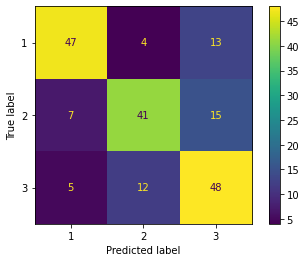


#### results for lowest loss model ####
Accuracy of: 0.7135


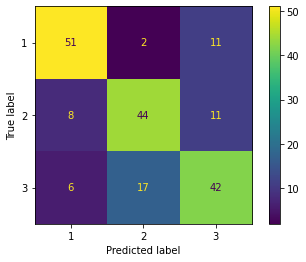


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9635 @ epoch 935
Best training loss (min) 0.1744 @ epoch 950

Best validation accuracy (max) 0.901 @ epoch 301
Best validation loss (min) 0.3569 @ epoch 376

#### results for highest accuracy model ####
Accuracy of: 0.9062


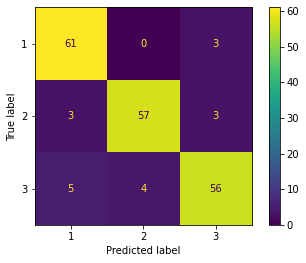


#### results for lowest loss model ####
Accuracy of: 0.8958


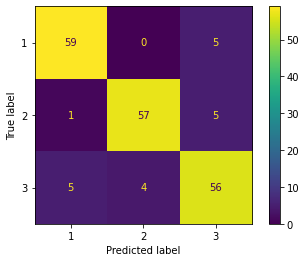


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9302 @ epoch 929
Best training loss (min) 0.2418 @ epoch 982

Best validation accuracy (max) 0.9058 @ epoch 478
Best validation loss (min) 0.3463 @ epoch 400

#### results for highest accuracy model ####
Accuracy of: 0.8272


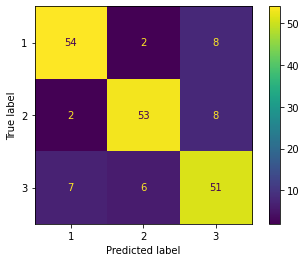


#### results for lowest loss model ####
Accuracy of: 0.8272


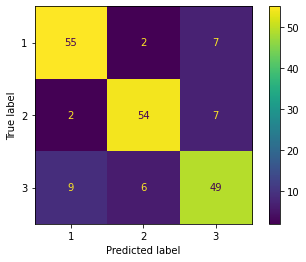

In [10]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 64, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 8, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0, ltsm_l2 = 0
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8125 @ epoch 214                   | 0.5254 @ epoch 439               | 0.7812                                           | 0.776                                             |
| C           | xxx                                  | xxx                              | xxx                                              | xxx                                               |
| E           | xxx                                  | xxx                              | xxx                                              | xxx                                               |

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id